In [1]:
import os, sys
import networkx as nx
from typing import Any

In [2]:
sys.path.append(os.path.join(os.getcwd(), 'structures'))
from structures.graph import Graph
from structures.problem import SearchResult
from structures.problems.map_coloring import MapColoringProblem
from structures.blind_search import bfs, dfs, ucs, iddfs, bidirectional_search

In [3]:
def print_result(name: str, res: SearchResult[Any, Any], show_solution: bool = True) -> None:
    print(f"\n== {name} ==")
    print(f"found: {res.found}")
    print(f"expanded: {res.expanded} | generated: {res.generated} | max_frontier: {res.max_frontier} | elapsed_ms: {res.elapsed_ms:.2f}")
    if res.found and show_solution:
        print(f"steps: {len(res.actions)} | path_cost: {res.path_cost}")
        # mostra assignments se houver
        if hasattr(res.state, "as_dict") and res.state is not None:
            A = res.state.as_dict()
            print("assignment:", A)

In [4]:
def build_brazil_map_graph() -> Graph:
    g = Graph(directed=False)
    edges = [
        ("AC", "AM"), ("AC", "RO"),
        ("AM", "RR"), ("AM", "PA"), ("AM", "RO"), ("AM", "MT"),
        ("RO", "MT"),
        ("RR", "PA"),
        ("PA", "MT"), ("PA", "AP"), ("PA", "TO"), ("PA", "MA"),
        ("TO", "MA"), ("TO", "PI"), ("TO", "BA"), ("TO", "GO"), ("TO", "MT"),
        ("MA", "PI"),
        ("PI", "BA"), ("PI", "PE"), ("PI", "CE"),
        ("CE", "RN"), ("CE", "PB"), ("CE", "PE"),
        ("RN", "PB"),
        ("PB", "PE"),
        ("PE", "AL"), ("PE", "BA"),
        ("AL", "SE"), ("AL", "BA"),
        ("SE", "BA"),
        ("BA", "GO"), ("BA", "MG"), ("BA", "ES"),
        ("MG", "GO"), ("MG", "ES"), ("MG", "RJ"), ("MG", "SP"), ("MG", "MS"),
        ("ES", "RJ"),
        ("RJ", "SP"),
        ("SP", "MS"), ("SP", "PR"),
        ("MT", "GO"), ("MT", "MS"),
        ("GO", "MS"), ("GO", "DF"),
        ("MS", "PR"),
        ("PR", "SC"),
        ("SC", "RS")
    ]

    for (u, v) in edges:
        g.add_edge(u, v)

    return g

In [51]:
# Definição do problema para o Brasil
g = build_brazil_map_graph()
colors = [1, 2, 3, 4]
order = ["RR", "AM", "AC", "RO", "AP", "PA", "TO", "MA", "PI", "CE", "RN", "PB", "PE", "AL", "SE", "BA", "MG", "ES", "RJ", "SP", "PR", "SC", "RS", "MT", "GO", "DF", "MS"]

problem = MapColoringProblem(g, colors, order)

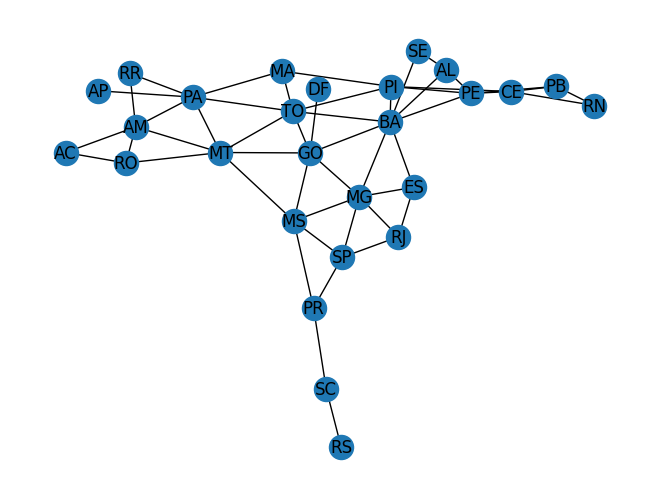

In [52]:
# plot using networkx
nx_graph = g.to_networkx()
nx.draw(nx_graph, with_labels=True)
import matplotlib.pyplot as plt
plt.show()

{}

In [15]:
def build_australia_map_graph() -> Graph:
    # Problema clássico mapa da Austrália com 7 regiões
    # WA, NT, SA, Q, NSW, V, T
    g = Graph(directed=False)
    edges = [
        ("WA", "NT"), ("WA", "SA"),
        ("NT", "SA"), ("NT", "Q"),
        ("SA", "Q"), ("SA", "NSW"), ("SA", "V"),
        ("Q", "NSW"),
        ("NSW", "V"),
        # T não tem fronteiras terrestres na formulação usual
    ]
    for u, v in edges:
        g.add_edge(u, v)

    # Adiciona nó isolado T
    g.add_node("T")
    return g

In [16]:
# Definição do problema
g = build_australia_map_graph()
colors = [1, 2, 3, 4]
order = ["WA", "NT", "SA", "Q", "NSW", "V", "T"]  # deterministic, blind

problem = MapColoringProblem(g, colors, order)

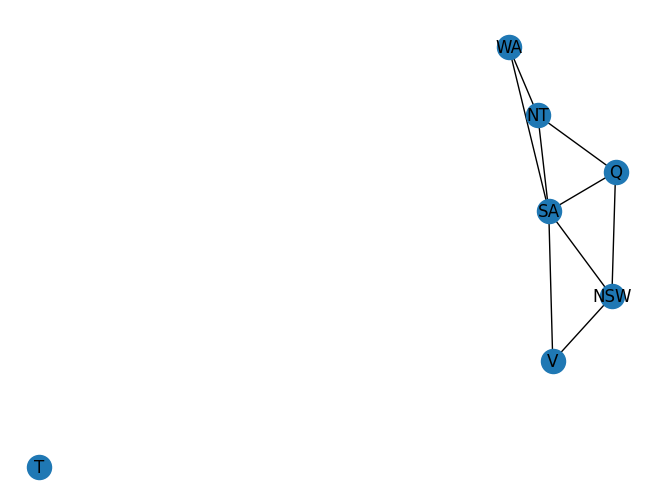

In [17]:
nx_graph = g.to_networkx()
nx.draw(nx_graph, with_labels=True)
plt.show()


In [ ]:
# BFS
res_bfs = bfs(problem)
print_result("BFS (busca em extensão)", res_bfs)


== BFS (busca em extensão) ==
found: True
expanded: 377 | generated: 1145 | max_frontier: 768 | elapsed_ms: 6.69
steps: 7 | path_cost: 7.0
assignment: {'NSW': 2, 'NT': 2, 'Q': 1, 'SA': 3, 'T': 1, 'V': 1, 'WA': 1}


In [30]:
res_bfs.state.as_dict().get('NSW')

2

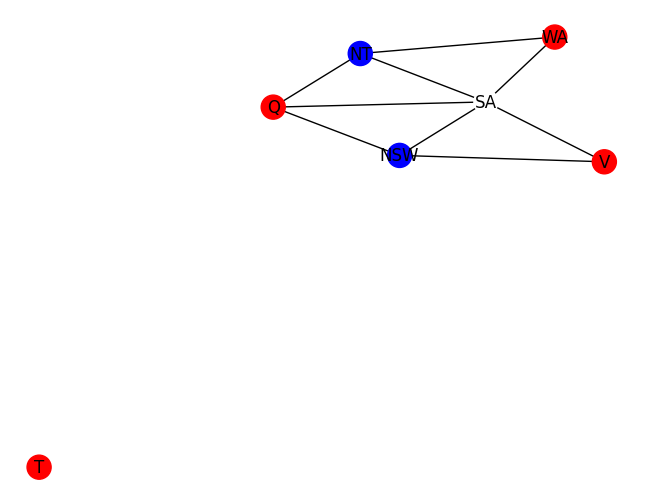

In [31]:
# plot network x graph with assignments
color_map = {1: 'red', 2: 'blue', 3: 'white', 4: 'black'}
res_bfs.state.assignments
nx_graph = g.to_networkx()
node_colors = [color_map[res_bfs.state.as_dict().get(node, 0)] for node in nx_graph.nodes()]
nx.draw(nx_graph, with_labels=True, node_color=node_colors)
plt.show()

In [53]:
# DFS
res_dfs = dfs(problem)
print_result("DFS (busca em profundidade)", res_dfs)


== DFS (busca em profundidade) ==
found: True
expanded: 27 | generated: 68 | max_frontier: 41 | elapsed_ms: 0.42
steps: 27 | path_cost: 27.0
assignment: {'AC': 4, 'AL': 4, 'AM': 3, 'AP': 4, 'BA': 1, 'CE': 4, 'DF': 4, 'ES': 3, 'GO': 3, 'MA': 3, 'MG': 4, 'MS': 2, 'MT': 1, 'PA': 2, 'PB': 2, 'PE': 3, 'PI': 2, 'PR': 4, 'RJ': 2, 'RN': 3, 'RO': 2, 'RR': 4, 'RS': 4, 'SC': 3, 'SE': 3, 'SP': 3, 'TO': 4}


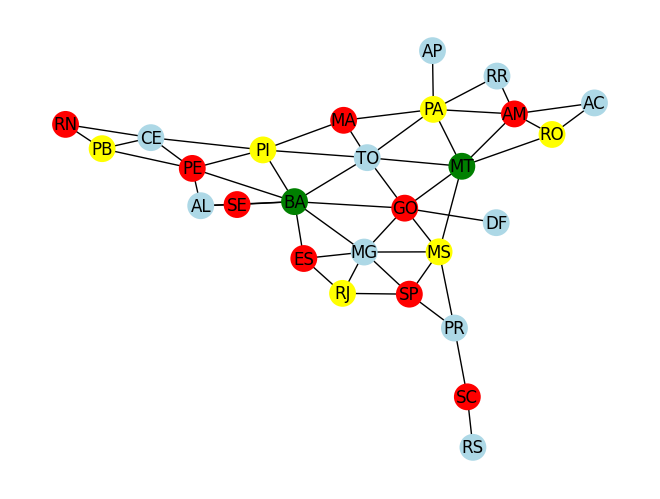

In [59]:
# plot network x graph with assignments
color_map = {1: 'green', 2: 'yellow', 3: 'red', 4: 'lightblue'}
res_dfs.state.assignments
nx_graph = g.to_networkx()
node_colors = [color_map[res_dfs.state.as_dict().get(node, 0)] for node in nx_graph.nodes()]
nx.draw(nx_graph, with_labels=True, node_color=node_colors, linewidths=2)
plt.show()

In [18]:
# UCS (mesmo custo por passo -> se comporta de forma semelhante ao BFS em camadas, mas com overhead da fila de prioridade)
res_ucs = ucs(problem)
print_result("UCS (custo uniforme)", res_ucs)


== UCS (custo uniforme) ==
found: True
expanded: 377 | generated: 1145 | max_frontier: 768 | elapsed_ms: 6.14
steps: 7 | path_cost: 7.0
assignment: {'NSW': 2, 'NT': 2, 'Q': 1, 'SA': 3, 'T': 1, 'V': 1, 'WA': 1}


In [16]:
# IDDFS (max depth = number of regions)
res_iddfs = iddfs(problem, max_depth=len(order))
print_result("IDDFS (aprofundamento iterativo)", res_iddfs)


== IDDFS (aprofundamento iterativo) ==
found: True
expanded: 345 | generated: 735 | max_frontier: 13 | elapsed_ms: 3.06
steps: 7 | path_cost: 7.0
assignment: {'NSW': 3, 'NT': 3, 'Q': 4, 'SA': 2, 'T': 4, 'V': 4, 'WA': 4}


In [19]:
# Bidirecional: precisa de um objetivo específico
# Para coloração de mapas, normalmente não sabemos isso com antecedência, então:
# 1) obtemos uma solução (por exemplo, do DFS) e
# 2) executamos a busca bidirecional entre o estado inicial e essa atribuição objetivo conhecida
if res_dfs.found and res_dfs.state is not None:
    goal_state = res_dfs.state
    res_bidir = bidirectional_search(problem, goal_state=goal_state)
    # Nota: ações incluem atribuições para frente + desatribuições para trás (limitação genérica).
    print_result("Bidirectional (requires known goal state)", res_bidir, show_solution=False)
    print("nota: para CSPs, bidirecional não é natural a menos que a atribuição exata do objetivo seja conhecida.")


== Bidirectional (requires known goal state) ==
found: True
expanded: 7 | generated: 9 | max_frontier: 2 | elapsed_ms: 0.09
nota: para CSPs, bidirecional não é natural a menos que a atribuição exata do objetivo seja conhecida.
